# Pokersters Fantasy Football Notebook
Lets do the data thang

In [1]:
# %pip install sleeper-api-wrapper
# %pip install matplotlib-label-lines

### Initialize

In [4]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 852044618987085824
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")
plt.rcParams['figure.figsize'] = [10, 5]

In [47]:
# import player projection data from spreadsheet
projection_file = '2022_projections/2022_week4_9-29-2022_ff_projection.txt'

with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv(projection_file, sep='\t', index_col=None)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player'].replace({'Gabriel Davis': 'Gabe Davis', 'Jeffery Wilson': 'Jeff Wilson', 'Kenneth Walker III': 'Kenneth Walker'}, inplace=True)
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert Gabe to Gabriel
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_15188/115772299.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,15.200000,17.000000,18.400000,1.390000,93.000000,7.980000,0.665000,1,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,RB,Christian McCaffrey,CAR,15.100000,16.300000,17.700000,1.190000,87.000000,7.320000,1.410000,2,NaN,NaN,Christian McCaffreyRB
2,3,NaN,NaN,TE,Mark Andrews,BAL,10.100000,11.400000,13.200000,1.680000,99.000000,7.070000,0.568000,1,NaN,NaN,Mark AndrewsTE
3,4,NaN,NaN,WR,Cooper Kupp,LAR,13.300000,14.600000,16.300000,1.400000,95.000000,6.620000,1.330000,1,NaN,NaN,Cooper KuppWR
4,5,NaN,NaN,QB,Josh Allen,BUF,22.000000,23.000000,24.200000,0.453000,9.000000,6.510000,1.250000,1,NaN,NaN,Josh AllenQB


In [48]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_15188/1579613147.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,depth_chart_position,fantasy_positions,age,injury_status,number,years_exp,fantasy_data_id,sport,birth_date,espn_id,...,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,[OL],27,None,60,1,16426,nfl,1991-04-22,17054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6250,None,[DL],None,NA,0,0,21183,nfl,None,3916426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4116,None,[OL],28,None,0,5,18962,nfl,1993-12-10,2972820,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8465,RG,[OL],22,None,74,0,None,nfl,2000-07-19,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6177,LDT,[DL],26,None,99,3,20934,nfl,1996-08-09,3121634,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [49]:
players_df.loc[[x for x in rosters_df.iloc[6]['starters'] if x != '0']].loc[:, ['full_name', 'Points', 'SD']]

,full_name,Points,SD
player_id,,,
4046,Patrick Mahomes,19.300000,1.880000
7528,Najee Harris,12.000000,0.445000
4866,Saquon Barkley,14.900000,0.578000
2216,Mike Evans,11.000000,0.340000
5927,Terry McLaurin,7.940000,0.222000
5906,Dawson Knox,5.180000,0.446000
3969,Leonard Fournette,13.000000,0.133000
7839,Evan McPherson,9.070000,0.608000
NYG,NaN,5.670000,0.899000


In [50]:
ffa_proj_df.head()

,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,15.200000,17.000000,18.400000,1.390000,93.000000,7.980000,0.665000,1,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,RB,Christian McCaffrey,CAR,15.100000,16.300000,17.700000,1.190000,87.000000,7.320000,1.410000,2,NaN,NaN,Christian McCaffreyRB
2,3,NaN,NaN,TE,Mark Andrews,BAL,10.100000,11.400000,13.200000,1.680000,99.000000,7.070000,0.568000,1,NaN,NaN,Mark AndrewsTE
3,4,NaN,NaN,WR,Cooper Kupp,LAR,13.300000,14.600000,16.300000,1.400000,95.000000,6.620000,1.330000,1,NaN,NaN,Cooper KuppWR
4,5,NaN,NaN,QB,Josh Allen,BUF,22.000000,23.000000,24.200000,0.453000,9.000000,6.510000,1.250000,1,NaN,NaN,Josh AllenQB


### Get Leaguemates data

In [51]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",852044618987085824,False,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'mascot_item_type_id_leg_6': 'tony-montana', ...",852044618987085824,False,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'mascot_item_type_id_leg_6': 'pizza', 'mascot...",852044618987085824,False,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Pacheco's Player Picture', 'men...",852044618987085824,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Waiting For 2023', 'mention_pn'...",852044618987085824,False,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'mascot_item_type_id_leg_6': 'ref', 'mascot_m...",852044618987085824,False,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",852044618987085824,True,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Hop on the Magic Gus Bus', 'men...",852044618987085824,False,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'mascot_item_type_id_leg_6': 'taco', 'mascot_...",852044618987085824,False,False,hunterm19,505a21249447d6533b5e1fc3dd53d755


In [52]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])

def get_bench(row):
    return [x for x in row['players'] if x not in row['starters']]

rosters_df['bench'] = rosters_df.apply(get_bench, axis=1)
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,keepers,co_owners,team_name,bench
0,None,"[3163, 6130, 7608, 4068, 7670, 4033, 6845, 704...","{'wins': 0, 'waiver_position': 2, 'waiver_budg...",1,[8154],"[3163, 4033, 4036, 4037, 4068, 5086, 6130, 684...",None,723630209273765888,"{'streak': '6L', 'record': 'LLLLLL'}",852044618987085824,[4068],None,Pacheco's Player Picture,"[4036, 4037, 5086, 7591, 8132, 8154, 8205]"
1,None,"[6904, 4098, 7607, 4039, 5872, 4217, 5045, 49,...","{'wins': 5, 'waiver_position': 8, 'waiver_budg...",2,None,"[4039, 4080, 4089, 4098, 4217, 49, 5045, 5872,...",None,375038190341611520,"{'streak': '5W', 'record': 'LWWWWW', 'p_nick_5...",852044618987085824,"[4039, 5872]",None,The Trolley Problems,"[4080, 4089, 5987, 8121, 8144, 8408]"
2,None,"[4984, 3198, 4199, 2133, 2309, 5844, 5937, 608...","{'wins': 5, 'waiver_position': 10, 'waiver_bud...",3,None,"[1352, 1479, 1825, 2133, 2309, 3198, 4199, 498...",None,607043401484926976,"{'streak': '2W', 'record': 'WWWLWW', 'p_nick_9...",852044618987085824,"[4984, 6806]",None,💩 King Henry,"[1352, 1479, 1825, 6806, 6828, 947]"
3,None,"[2028, 5284, 6820, 3321, 2197, 5133, 4149, 391...","{'wins': 2, 'waiver_position': 11, 'waiver_bud...",4,None,"[2028, 2197, 2374, 3225, 3321, 3664, 391, 4149...",None,723633476015857664,"{'streak': '1W', 'record': 'WLLLLW'}",852044618987085824,[2197],None,Waiting For 2023,"[2374, 3225, 3664, 5001, 6938, 7567]"
4,None,"[6797, 6955, 1535, 2449, 4950, 1466, 5892, 466...","{'wins': 6, 'waiver_position': 1, 'waiver_budg...",5,None,"[1466, 1535, 2449, 3214, 4666, 4950, 5347, 589...",None,608864437348163584,"{'streak': '6W', 'restrict_pn_scoring_starters...",852044618987085824,[6797],None,Kneel Before the 👑,"[3214, 5347, 5947, 7527, 7611, 8135]"


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


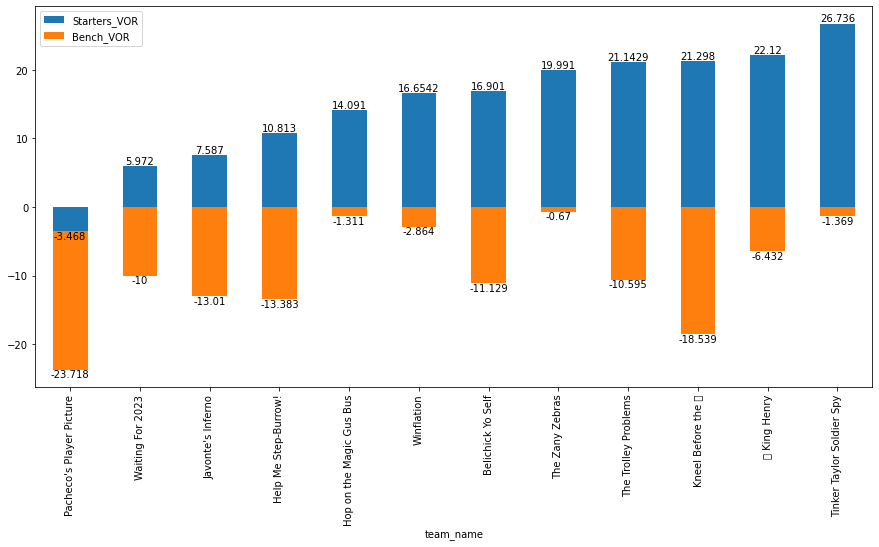

In [53]:
#  Post-draft VOR calculation
plt.rcParams['figure.figsize'] = [15, 7]
rosters_df['Starters_VOR'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Bench_VOR'] = rosters_df['bench'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Team_VOR'] = rosters_df['players'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))

ax = rosters_df.sort_values('Starters_VOR')[['Starters_VOR', 'Bench_VOR', 'team_name']].plot.bar(x='team_name', stacked=True)
for container in ax.containers:
    ax.bar_label(container)

[Text(0, 0, '-3.468'),
 Text(0, 0, '5.972'),
 Text(0, 0, '7.587'),
 Text(0, 0, '10.813'),
 Text(0, 0, '14.091'),
 Text(0, 0, '16.6542'),
 Text(0, 0, '16.901'),
 Text(0, 0, '19.991'),
 Text(0, 0, '21.1429'),
 Text(0, 0, '21.298'),
 Text(0, 0, '22.12'),
 Text(0, 0, '26.736')]

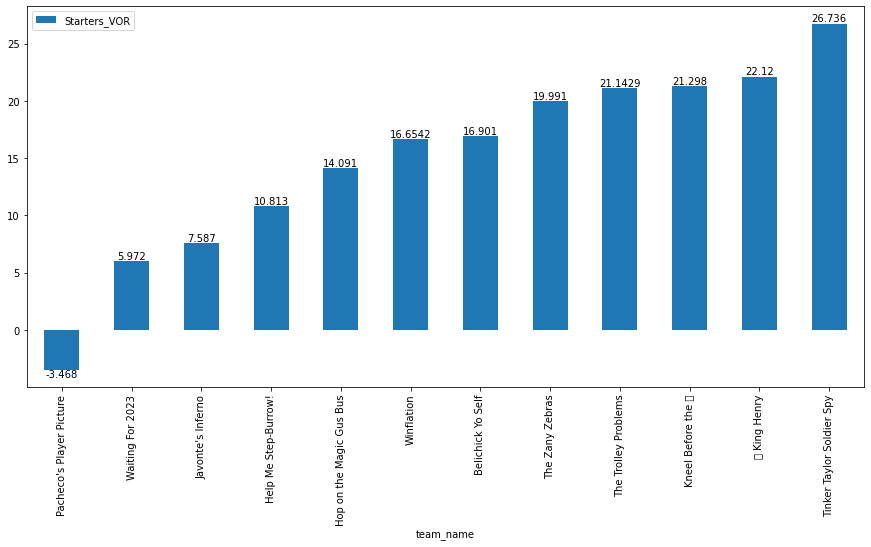

In [54]:
ax = rosters_df.sort_values('Starters_VOR').plot.bar(x='team_name', y='Starters_VOR')
ax.bar_label(ax.containers[0])


In [55]:
for col in ['Floor','Points','Ceiling','Uncertainty']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)

In [59]:
players_df.loc[[x for x in rosters_df.iloc[11]['players'] if x != '0']].loc[:, ['full_name', 'Points', 'SD', 'VOR']]

,full_name,Points,SD,VOR
player_id,,,,
1166,Kirk Cousins,15.300000,0.712000,-1.110000
1234,Russell Wilson,16.200000,0.577000,-0.270000
1339,Zach Ertz,6.130000,0.571000,1.770000
2749,Raheem Mostert,6.200000,1.320000,-2.800000
4082,Curtis Samuel,7.500000,0.256000,-0.431000
503,Graham Gano,8.390000,0.785000,-0.422000
6659,Craig Reynolds,4.050000,1.330000,-4.950000
6819,Michael Pittman,9.790000,0.179000,1.860000
7588,Javonte Williams,10.900000,0.200000,1.860000


[Text(0, 0, '66.63'),
 Text(0, 0, '84.01'),
 Text(0, 0, '84.54'),
 Text(0, 0, '87.72'),
 Text(0, 0, '91.95'),
 Text(0, 0, '93.74'),
 Text(0, 0, '94.56'),
 Text(0, 0, '98.06'),
 Text(0, 0, '98.11'),
 Text(0, 0, '99.05'),
 Text(0, 0, '99.29'),
 Text(0, 0, '103.64')]

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


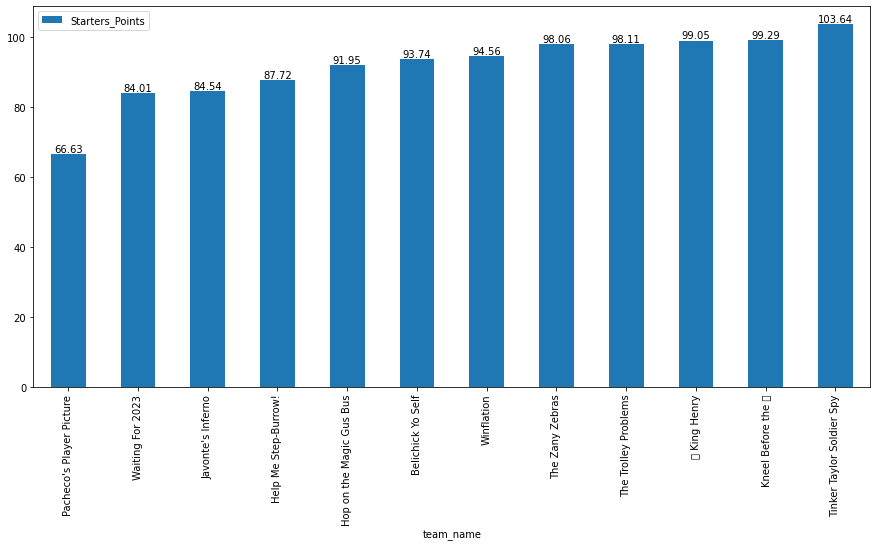

In [60]:
ax = rosters_df.sort_values('Starters_Points').plot.bar(x='team_name', y='Starters_Points')
ax.bar_label(ax.containers[0])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


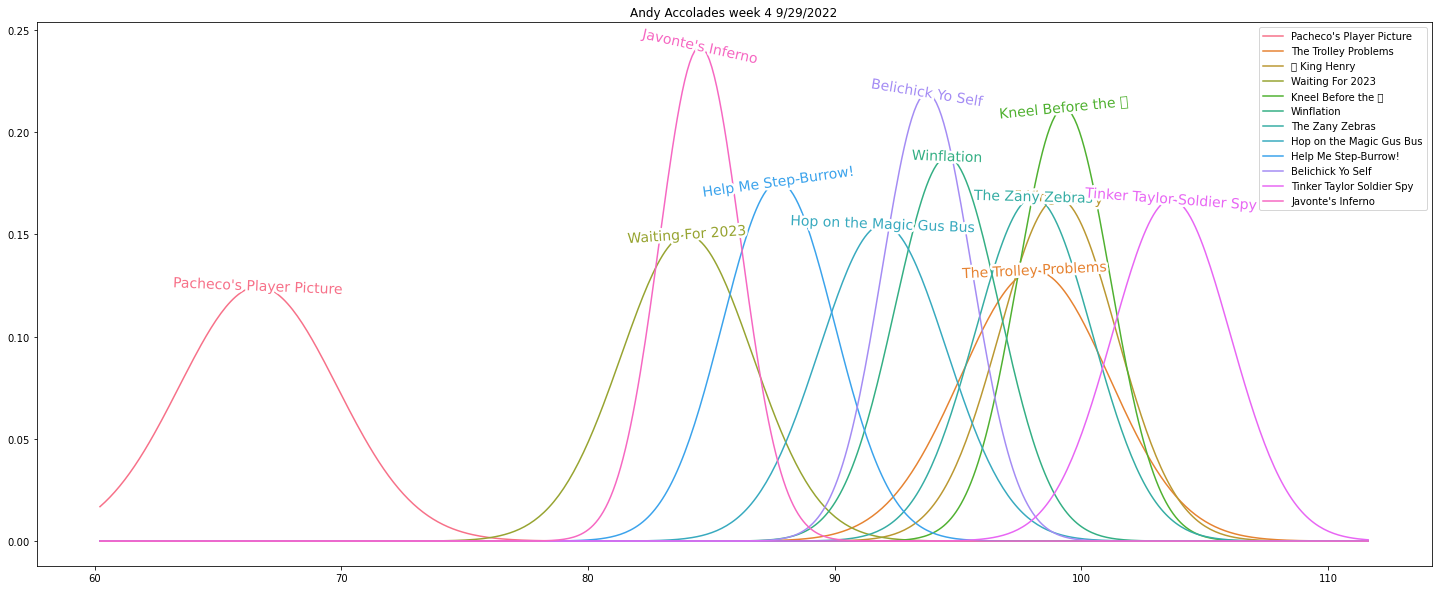

In [61]:
plt.rcParams['figure.figsize'] = [25, 10]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Points'].min() - 2*rosters_df['Starters_SD'].max(), rosters_df['Starters_Points'].max() + 2.5*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Points'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Points'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Accolades week 4 9/29/2022')
plt.show()

In [62]:
rosters_df.loc[:, ['team_name', 'Starters_Points', 'Starters_SD']].sort_values(by='Starters_Points')

,team_name,Starters_Points,Starters_SD
0,Pacheco's Player Picture,66.630000,3.204994
3,Waiting For 2023,84.010000,2.664794
11,Javonte's Inferno,84.540000,1.650181
8,Help Me Step-Burrow!,87.720000,2.272401
7,Hop on the Magic Gus Bus,91.950000,2.577118
9,Belichick Yo Self,93.740000,1.821092
5,Winflation,94.560000,2.122722
6,The Zany Zebras,98.060000,2.371890
1,The Trolley Problems,98.110000,3.016404
2,💩 King Henry,99.050000,2.377942


In [63]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Ceiling')

,team_name,Starters_Ceiling,Starters_Floor
0,Pacheco's Player Picture,78.380000,56.330000
11,Javonte's Inferno,92.570000,76.310000
3,Waiting For 2023,95.220000,71.670000
8,Help Me Step-Burrow!,98.350000,82.390000
7,Hop on the Magic Gus Bus,99.700000,84.510000
9,Belichick Yo Self,102.820000,86.230000
5,Winflation,104.880000,85.270000
1,The Trolley Problems,107.020000,89.350000
2,💩 King Henry,108.040000,90.910000
6,The Zany Zebras,108.180000,90.100000


In [65]:
week = 4
matchups = league.get_matchups(week)
matchups_df = pd.DataFrame(matchups)
mu = matchups_df.groupby('matchup_id')

In [71]:
num_matchups = len(rosters_df) // 2

matchup_prob_df = pd.DataFrame()


pd.set_option('display.float_format', '{:.6f}'.format)

for i in range(1, num_matchups+1):
    p1, p2 = mu.get_group(i)['roster_id'].iloc[0] - 1, mu.get_group(i)['roster_id'].iloc[1] - 1
    d_mean = rosters_df.iloc[p1]['Starters_Points'] - rosters_df.iloc[p2]['Starters_Points']
    d_var = rosters_df.iloc[p1]['Starters_Variance'] + rosters_df.iloc[p2]['Starters_Variance']
    # victory_prob = (1 - norm(d_mean, d_var**(1/2)).cdf(0))
    victory_prob = (1 - norm(d_mean, d_var).cdf(0))
    row = {'team1': rosters_df.iloc[p1]['team_name'], 'team2': rosters_df.iloc[p2]['team_name'], 'victory_probability': victory_prob, 'd_mean': d_mean, 'd_var': d_var}
    matchup_prob_df = matchup_prob_df.append(row, ignore_index=True)

print(matchup_prob_df.loc[:, ['team1', 'team2', 'victory_probability']])

                      team1                      team2  victory_probability
0  Pacheco's Player Picture           Waiting For 2023             0.158559
1         Belichick Yo Self  Tinker Taylor Soldier Spy             0.136230
2           The Zany Zebras          Javonte's Inferno             0.947315
3                Winflation       Help Me Step-Burrow!             0.760329
4        Kneel Before the 👑   Hop on the Magic Gus Bus             0.764338
5      The Trolley Problems               💩 King Henry             0.474599


In [67]:
players_df[players_df['Position'] == 'DST']['VOR'].sort_values()

player_id
LV    -1.610000
SEA   -1.490000
CAR   -1.280000
NE    -1.180000
KC    -1.170000
ATL   -1.170000
NYJ   -1.170000
JAX   -1.080000
TB    -0.970000
WAS   -0.960000
NO    -0.880000
BAL   -0.880000
HOU   -0.550000
DET   -0.450000
ARI   -0.405000
CIN   -0.312000
DEN   -0.270000
IND   -0.200000
PHI   -0.170000
LAC   -0.120000
LAR   -0.105000
TEN   -0.060000
SF     0.000000
NYG    0.193000
CHI    0.242000
GB     0.320000
CLE    0.463000
MIN    0.647000
MIA    0.737000
BUF    0.773000
DAL    1.180000
PIT    1.350000
Name: VOR, dtype: float64